In [23]:

"""
Cubic spline planner

Author: Atsushi Sakai(@Atsushi_twi)

"""
import math
import numpy as np
import bisect


class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position

        if t is outside of the input x, return None

        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative

        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """
    2D Cubic Spline class

    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s


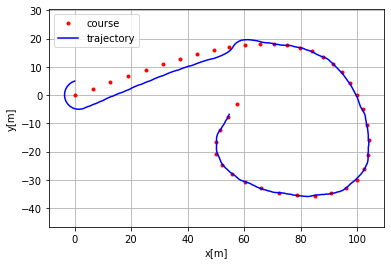

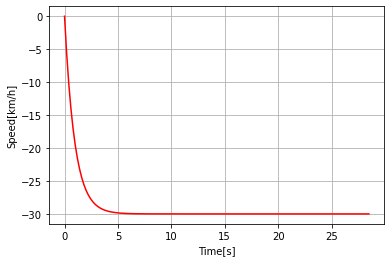

In [24]:

"""

Path tracking simulation with Stanley steering control and PID speed control.

author: Atsushi Sakai (@Atsushi_twi)

Ref:
    - [Stanley: The robot that won the DARPA grand challenge](http://isl.ecst.csuchico.edu/DOCS/darpa2005/DARPA%202005%20Stanley.pdf)
    - [Autonomous Automobile Path Tracking](https://www.ri.cmu.edu/pub_files/2009/2/Automatic_Steering_Methods_for_Autonomous_Automobile_Path_Tracking.pdf)

"""
import numpy as np
import matplotlib.pyplot as plt

k = 0.5  # control gain
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time difference
L = 2.9  # [m] Wheel base of vehicle
max_steer = np.radians(30.0)  # [rad] max steering angle

show_animation = True


class State(object):
    """
    Class representing the state of a vehicle.

    :param x: (float) x-coordinate
    :param y: (float) y-coordinate
    :param yaw: (float) yaw angle
    :param v: (float) speed
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        """Instantiate the object."""
        super(State, self).__init__()
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v

    def update(self, acceleration, delta):
        """
        Update the state of the vehicle.

        Stanley Control uses bicycle model.

        :param acceleration: (float) Acceleration
        :param delta: (float) Steering
        """
        delta = np.clip(delta, -max_steer, max_steer)

        self.x += self.v * np.cos(self.yaw) * dt
        self.y += self.v * np.sin(self.yaw) * dt
        self.yaw += self.v / L * np.tan(delta) * dt
        self.yaw = normalize_angle(self.yaw)
        self.v += acceleration * dt


def pid_control(target, current):
    """
    Proportional control for the speed.

    :param target: (float)
    :param current: (float)
    :return: (float)
    """
    return Kp * (target - current)


def stanley_control(state, cx, cy, cyaw, last_target_idx):
    """
    Stanley steering control.

    :param state: (State object)
    :param cx: ([float])
    :param cy: ([float])
    :param cyaw: ([float])
    :param last_target_idx: (int)
    :return: (float, int)
    """
    current_target_idx, error_front_axle = calc_target_index(state, cx, cy)

    if last_target_idx >= current_target_idx:
        current_target_idx = last_target_idx

    # theta_e corrects the heading error
    theta_e = normalize_angle(cyaw[current_target_idx] - state.yaw)
    # theta_d corrects the cross track error
    theta_d = np.arctan2(k * error_front_axle, state.v)
    # Steering control
    delta = theta_e + theta_d

    return delta, current_target_idx


def normalize_angle(angle):
    """
    Normalize an angle to [-pi, pi].

    :param angle: (float)
    :return: (float) Angle in radian in [-pi, pi]
    """
    while angle > np.pi:
        angle -= 2.0 * np.pi

    while angle < -np.pi:
        angle += 2.0 * np.pi

    return angle


def calc_target_index(state, cx, cy):
    """
    Compute index in the trajectory list of the target.

    :param state: (State object)
    :param cx: [float]
    :param cy: [float]
    :return: (int, float)
    """
    # Calc front axle position
    # change the formula to a '+' to get forwards driving
    fx = state.x - L * np.cos(state.yaw)
    fy = state.y - L * np.sin(state.yaw)

    # Search nearest point index
    dx = [fx - icx for icx in cx]
    dy = [fy - icy for icy in cy]
    d = np.hypot(dx, dy)
    target_idx = np.argmin(d)

    # Project RMS error onto front axle vector
    front_axle_vec = [-np.cos(state.yaw + np.pi / 2),
                      -np.sin(state.yaw + np.pi / 2)]
    error_front_axle = np.dot([dx[target_idx], dy[target_idx]], front_axle_vec)

    return target_idx, error_front_axle


def main():
    """Plot an example of Stanley steering control on a cubic spline."""
    #  target course
    ax = [0.0, 100.0, 100.0, 50.0, 60.0]
    ay = [0.0, 0.0, -30.0, -20.0, 0.0]

    cx, cy, cyaw, ck, s = calc_spline_course(
        ax, ay, ds=5)

    target_speed = -30.0 / 3.6  # [m/s]

    max_simulation_time = 100.0

    # Initial state
    state = State(x=-0.0, y=5.0, yaw=np.radians(20.0), v=0.0)

    last_idx = len(cx) - 1
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    target_idx, _ = calc_target_index(state, cx, cy)
    while max_simulation_time >= time and last_idx > target_idx:
        ai = pid_control(target_speed, state.v)
        di, target_idx = stanley_control(state, cx, cy, cyaw, target_idx)
        state.update(ai, di)

        time += dt

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        # remove False to animate it
        if show_animation and False:  # pragma: no cover
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                                         lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(cx, cy, ".r", label="course")
            plt.plot(x, y, "-b", label="trajectory")
            plt.plot(cx[target_idx], cy[target_idx], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
            plt.pause(0.001)

    # Test
    assert last_idx >= target_idx, "Cannot reach goal"

    if show_animation:  # pragma: no cover
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(x, y, "-b", label="trajectory")
        plt.legend()
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.axis("equal")
        plt.grid(True)

        plt.subplots(1)
        plt.plot(t, [iv * 3.6 for iv in v], "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("Speed[km/h]")
        plt.grid(True)
        plt.show()


if __name__ == '__main__':
    main()
